<font size="+3">Visualize Real and Synthetic Data</font>

# Imports and Settings

In [1]:
from pathlib import Path

import numpy as np
import pandas as pd

from sklearn.manifold import TSNE
from sklearn.decomposition import PCA
from sklearn.preprocessing import MinMaxScaler

import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import GRU, Dense
from tensorflow.keras.losses import BinaryCrossentropy, MeanSquaredError, MeanAbsoluteError
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.metrics import AUC

import matplotlib.pyplot as plt
import seaborn as sns

C:\Users\capil\AppData\Local\Temp\ipykernel_21956\3277978445.py:4: DeprecationWarning: 
Pyarrow will become a required dependency of pandas in the next major release of pandas (pandas 3.0),
(to allow more performant data types, such as the Arrow string type, and better interoperability with other libraries)
but was not found to be installed on your system.
If this would cause problems for you,
please provide us feedback at https://github.com/pandas-dev/pandas/issues/54466
        
  import pandas as pd


In [2]:
path = Path('time_gan')
hdf_store = path / 'TimeSeriesGAN.h5'

In [3]:
seq_len = 24
n_seq = 20

# Load Data

In [4]:
real_data=np.load('scaled_real_train_data_array.npy')
synthetic_data=np.load('scaled_synthetic_data_array_gan.npy')

In [5]:
n = len(real_data)

In [6]:
np.asarray(real_data).shape

(3982, 24, 20)

In [7]:
real_data = real_data[:synthetic_data.shape[0]]

# Prepare Sample

In [8]:
sample_size = 250
idx = np.random.permutation(len(real_data))[:sample_size]

In [9]:
real_sample = np.asarray(real_data)[idx]
synthetic_sample = np.asarray(synthetic_data)[idx]

In [10]:
real_sample_2d = real_sample.reshape(-1, seq_len)
synthetic_sample_2d = synthetic_sample.reshape(-1, seq_len)

In [11]:
real_sample_2d.shape, synthetic_sample_2d.shape

((5000, 24), (5000, 24))

# Visualization in 2D: A Qualitative Assessment of Diversity

## Run PCA

In [36]:
pca = PCA(n_components=2)
pca.fit(real_sample_2d)
pca_real = (pd.DataFrame(pca.transform(real_sample_2d))
            .assign(Data='Reales'))
pca_synthetic = (pd.DataFrame(pca.transform(synthetic_sample_2d))
                 .assign(Data='Sintéticos'))
pca_result = pd.concat([pca_real, pca_synthetic], ignore_index=True).rename(
    columns={0: '1st Component', 1: '2nd Component'})

## Run t-SNE

In [37]:
tsne_data = np.concatenate((real_sample_2d,
                            synthetic_sample_2d), axis=0)

tsne = TSNE(n_components=2,
            verbose=1,
            perplexity=40)
tsne_result = tsne.fit_transform(tsne_data)

[t-SNE] Computing 121 nearest neighbors...
[t-SNE] Indexed 10000 samples in 0.001s...
[t-SNE] Computed neighbors for 10000 samples in 0.332s...
[t-SNE] Computed conditional probabilities for sample 1000 / 10000
[t-SNE] Computed conditional probabilities for sample 2000 / 10000
[t-SNE] Computed conditional probabilities for sample 3000 / 10000
[t-SNE] Computed conditional probabilities for sample 4000 / 10000
[t-SNE] Computed conditional probabilities for sample 5000 / 10000
[t-SNE] Computed conditional probabilities for sample 6000 / 10000
[t-SNE] Computed conditional probabilities for sample 7000 / 10000
[t-SNE] Computed conditional probabilities for sample 8000 / 10000
[t-SNE] Computed conditional probabilities for sample 9000 / 10000
[t-SNE] Computed conditional probabilities for sample 10000 / 10000
[t-SNE] Mean sigma: 0.107968
[t-SNE] KL divergence after 250 iterations with early exaggeration: 58.334099
[t-SNE] KL divergence after 1000 iterations: 0.384656


In [38]:
tsne_result = pd.DataFrame(tsne_result, columns=['X', 'Y']).assign(Data='Reales')
tsne_result.loc[sample_size*20:, 'Data'] = 'Sintéticos'

In [39]:
pca_result=pca_result.rename({'Data':'Datos', '1st Component': '1º Componente','2nd Component': '2º Componente'},axis=1)
tsne_result=tsne_result.rename({'Data':'Datos'},axis=1)

In [40]:
pca_result

,1º Componente,2º Componente,Datos
0,-0.649813,0.645603,Reales
1,0.346834,-0.726496,Reales
2,-0.283834,0.157456,Reales
3,0.111954,-0.255097,Reales
4,-0.052878,-0.109419,Reales
...,...,...,...
9995,0.771333,0.326232,Sintéticos
9996,1.057513,0.013949,Sintéticos
9997,1.061198,-0.057271,Sintéticos
9998,0.794319,0.184090,Sintéticos


## Plot Result

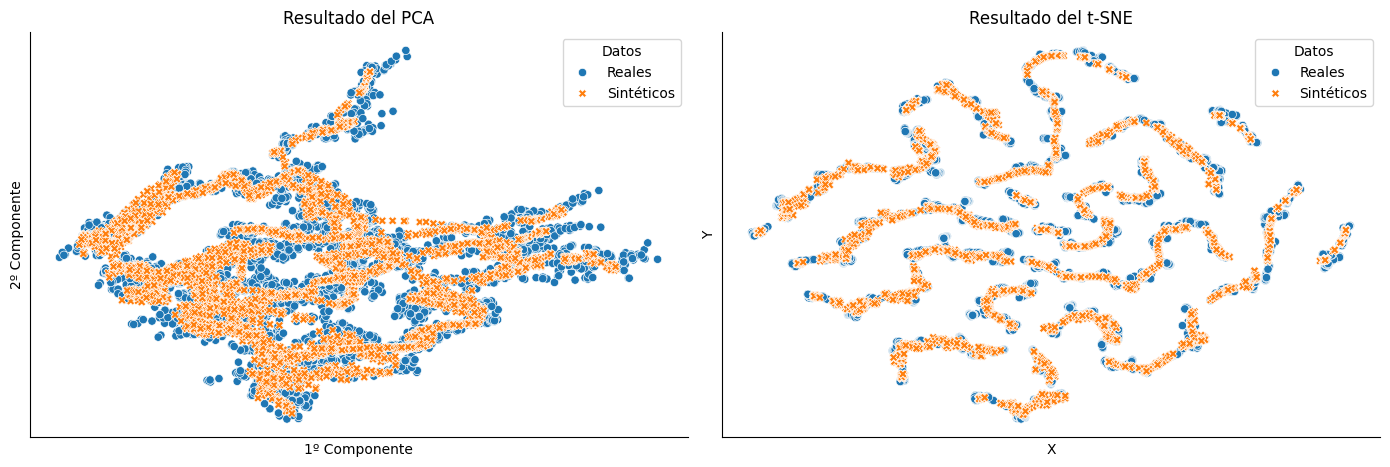

In [41]:
fig, axes = plt.subplots(ncols=2, figsize=(14, 5))

sns.scatterplot(x='1º Componente', y='2º Componente', data=pca_result,
                hue='Datos', style='Datos', ax=axes[0])
sns.despine()
axes[0].set_title('Resultado del PCA')


sns.scatterplot(x='X', y='Y',
                data=tsne_result,
                hue='Datos', 
                style='Datos', 
                ax=axes[1])
sns.despine()
for i in [0, 1]:
    axes[i].set_xticks([])
    axes[i].set_yticks([])

axes[1].set_title('Resultado del t-SNE')
#fig.suptitle('Assessing Diversity: Qualitative Comparison of Real and Synthetic Data Distributions', 
          #   fontsize=14)
fig.tight_layout()
fig.subplots_adjust(top=.88);
plt.savefig('evaluacion_visual_gan.png')

# Time Series Classification: A quantitative Assessment of Fidelity

## Prepare Data

In [31]:
real_data = np.array(real_data)[:len(synthetic_data)]
real_data.shape

(3982, 24, 20)

In [32]:
synthetic_data.shape

(4992, 24, 20)

In [33]:
n_series = real_data.shape[0]

In [34]:
idx = np.arange(n_series)

In [35]:
n_train = int(.8*n_series)
train_idx = idx[:n_train]
test_idx = idx[n_train:]

In [36]:
train_data = np.vstack((real_data[train_idx], 
                        synthetic_data[train_idx]))
test_data = np.vstack((real_data[test_idx], 
                       synthetic_data[test_idx]))

In [37]:
n_train, n_test = len(train_idx), len(test_idx)
train_labels = np.concatenate((np.ones(n_train),
                               np.zeros(n_train)))
test_labels = np.concatenate((np.ones(n_test),
                              np.zeros(n_test)))

## Create Classifier

In [38]:
ts_classifier = Sequential([GRU(20, input_shape=(24, 20), name='GRU'),
                            Dense(1, activation='sigmoid', name='OUT')],
                           name='Time_Series_Classifier')

In [39]:
ts_classifier.compile(loss='binary_crossentropy',
                      optimizer=Adam(learning_rate=0.0001),
                      metrics=[AUC(name='AUC'), 'accuracy'])

In [40]:
ts_classifier.summary()

Model: "Time_Series_Classifier"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 GRU (GRU)                   (None, 20)                2520      
                                                                 
 OUT (Dense)                 (None, 1)                 21        
                                                                 
Total params: 2541 (9.93 KB)
Trainable params: 2541 (9.93 KB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________


In [41]:
result = ts_classifier.fit(x=train_data,
                           y=train_labels,
                           validation_data=(test_data, test_labels),
                           epochs=250,
                           batch_size=128,
                           verbose=0)

In [42]:
ts_classifier.evaluate(x=test_data, y=test_labels)

50/50 [==============================] - 0s 4ms/step - loss: 3.2366 - AUC: 0.1140 - accuracy: 0.3664


[3.2366325855255127, 0.1140451431274414, 0.3663738965988159]

In [43]:
history = pd.DataFrame(result.history)
history.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 250 entries, 0 to 249
Data columns (total 6 columns):
 #   Column        Non-Null Count  Dtype  
---  ------        --------------  -----  
 0   loss          250 non-null    float64
 1   AUC           250 non-null    float64
 2   accuracy      250 non-null    float64
 3   val_loss      250 non-null    float64
 4   val_AUC       250 non-null    float64
 5   val_accuracy  250 non-null    float64
dtypes: float64(6)
memory usage: 11.8 KB


In [44]:
from matplotlib.ticker import FuncFormatter

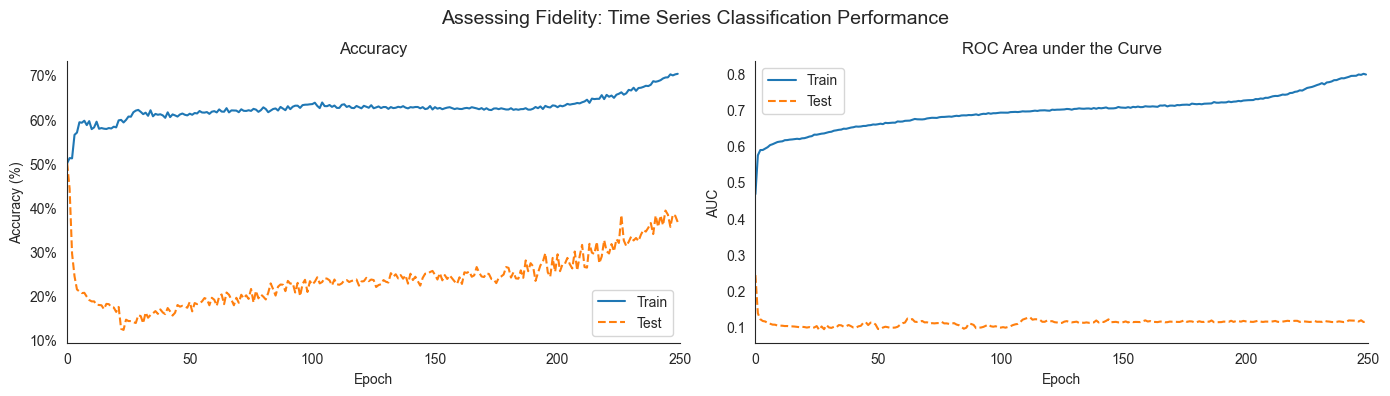

In [45]:
sns.set_style('white')
fig, axes = plt.subplots(ncols=2, figsize=(14,4))
history[['AUC', 'val_AUC']].rename(columns={'AUC': 'Train', 'val_AUC': 'Test'}).plot(ax=axes[1], 
                                                                                     title='ROC Area under the Curve',
                                                                                    style=['-', '--'],
                                                                                    xlim=(0, 250))
history[['accuracy', 'val_accuracy']].rename(columns={'accuracy': 'Train', 'val_accuracy': 'Test'}).plot(ax=axes[0], 
                                                                                                         title='Accuracy',
                                                                                                        style=['-', '--'],
                                                                                                        xlim=(0, 250))
for i in [0, 1]:
    axes[i].set_xlabel('Epoch')

axes[0].yaxis.set_major_formatter(FuncFormatter(lambda y, _: '{:.0%}'.format(y))) 
axes[0].set_ylabel('Accuracy (%)')
axes[1].set_ylabel('AUC')
sns.despine()
fig.suptitle('Assessing Fidelity: Time Series Classification Performance', fontsize=14)
fig.tight_layout()
fig.subplots_adjust(top=.85);

# Train on Synthetic, test on real: Assessing usefulness

In [46]:
real_train_data=np.load('scaled_real_train_data_array.npy')
real_test_data=np.load('scaled_real_test_data_array.npy')
synthetic_data=np.load('scaled_synthetic_data_array_gan.npy')

In [47]:
real_train_data = real_data[:, :23, :]
real_train_label = real_data[:, -1, :]

real_test_data = real_data[:, :23, :]
real_test_label = real_data[:, -1, :]

synthetic_train = synthetic_data[:, :23, :]
synthetic_label = synthetic_data[:, -1, :]

In [48]:
real_train_data.shape, real_train_label.shape, real_test_data.shape, real_test_label.shape

((3982, 23, 20), (3982, 20), (3982, 23, 20), (3982, 20))

In [49]:
synthetic_train.shape, synthetic_label.shape

((4992, 23, 20), (4992, 20))

In [50]:
def get_model():
    model = Sequential([GRU(32, input_shape=(seq_len-1, n_seq)),
                        Dense(20)])

    model.compile(optimizer=Adam(learning_rate=0.0001),
                  loss=MeanAbsoluteError(name='MAE'))
    return model

In [51]:
ts_regression = get_model()
synthetic_result = ts_regression.fit(x=synthetic_train,
                                     y=synthetic_label,
                                     validation_data=(
                                         real_test_data, 
                                         real_test_label),
                                     epochs=100,
                                     batch_size=128,
                                     verbose=0)

In [52]:
ts_regression.evaluate(x=real_test_data, y=real_test_label)

125/125 [==============================] - 0s 4ms/step - loss: 0.0246


0.024634702131152153

In [53]:
ts_regression = get_model()
real_result = ts_regression.fit(x=real_train_data,
                                y=real_train_label,
                                validation_data=(
                                    real_test_data, 
                                    real_test_label),
                                epochs=100,
                                batch_size=128,
                                verbose=0)

In [54]:
ts_regression.evaluate(x=real_test_data, y=real_test_label)

125/125 [==============================] - 0s 4ms/step - loss: 0.0240


0.024047182872891426

In [55]:
synthetic_result = pd.DataFrame(synthetic_result.history).rename(columns={'loss': 'Train', 'val_loss': 'Test'})
real_result = pd.DataFrame(real_result.history).rename(columns={'loss': 'Train', 'val_loss': 'Test'})

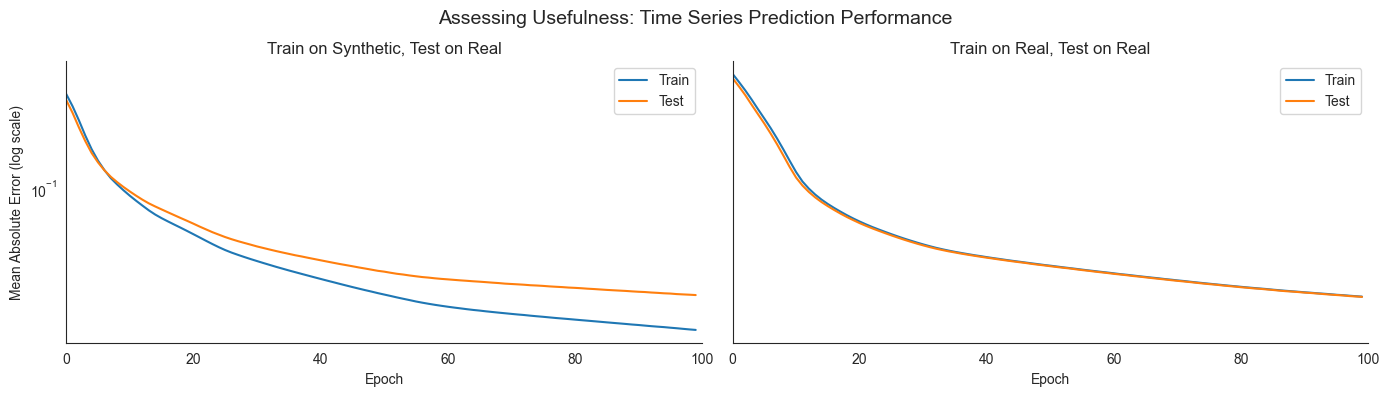

In [56]:
fig, axes = plt.subplots(ncols=2, figsize=(14, 4), sharey=True)
synthetic_result.plot(ax=axes[0], title='Train on Synthetic, Test on Real', logy=True, xlim=(0, 100))
real_result.plot(ax=axes[1], title='Train on Real, Test on Real', logy=True, xlim=(0, 100))
for i in [0, 1]:
    axes[i].set_xlabel('Epoch')
    axes[i].set_ylabel('Mean Absolute Error (log scale)')

sns.despine()
fig.suptitle('Assessing Usefulness: Time Series Prediction Performance', fontsize=14)
fig.tight_layout()
fig.subplots_adjust(top=.85);